# Main Figure

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using LaTeXStrings
using TrajectoryIndexingUtils
using SparseArrays
using Statistics
using CairoMakie
using Random
using NamedTrajectories
using JLD2, FileIO

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryUniversalProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryUniversalProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243


In [2]:
# Problem parameters
T = 40
Δt = 0.8
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)
seeds = rand(1:1000, 25)
F=0.9999
num_iter = 6000
hess = false
hess_iter = 120
Qs = 10 .^ range(-4.0, 1.0, length=25)
a_bound = 1.0
dda_bound = 0.5
R=5e-3

# variational
∂ₑHₐ = [PAULIS.Z]
varsys_add = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)
n_seeds = length(seeds)
nQ = length(Qs)

25

In [3]:
# Directories where data is saved
var_dir = "artifacts/var_gap_data_export"
tog_dir = "artifacts/tog_gap_data_export"

# Load the first seed file to get metadata
var_first = load(joinpath(var_dir, "var_probs_seed_idx_1.jld2"))
tog_first = load(joinpath(tog_dir, "htog_probs_seed_idx_1.jld2"))

# Extract common parameters
Qs = var_first["Qs"]

n_seeds = length(readdir(var_dir)) - 1  # Subtract 1 for plot.png

# Initialize arrays to store loaded data
var_probs = Matrix{Any}(undef, n_seeds, length(Qs))
tog_probs = Matrix{Any}(undef, n_seeds, length(Qs))

# Load all var_probs data
for i in 1:n_seeds
    data = load(joinpath(var_dir, "var_probs_seed_idx_$(i).jld2"))
    var_probs[i, :] = data["var_probs"]
end

# Load all htog_probs data
for i in 1:n_seeds
    data = load(joinpath(tog_dir, "htog_probs_seed_idx_$(i).jld2"))
    tog_probs[i, :] = data["htog_probs"]
end

println("Loaded data for $(n_seeds) seeds across $(length(Qs)) Q values")

Loaded data for 25 seeds across 25 Q values


In [4]:
function var_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}}, 
    H_errors::Vector{Matrix{ComplexF64}},
    t_cut::Int=traj.T,
)
    Δt = traj.Δt[1]
    varsys = VariationalQuantumSystem(H_drives, H_errors)
    Ũ⃗, ∂Ũ⃗ = variational_unitary_rollout(traj, varsys)

    # Get dimension from first operator
    d = size(iso_vec_to_operator(Ũ⃗[:, 1]), 1)
    
    # Sum the objective over all timesteps from 1 to t_cut
    total = 0.0
    for t in 1:t_cut
        U_t = iso_vec_to_operator(Ũ⃗[:, t])
        ∂U_t = iso_vec_to_operator(∂Ũ⃗[1][:, t])
        # Compute ||U†∂U||² = tr((U†∂U)†(U†∂U))
        term = (U_t' * ∂U_t)' * (U_t' * ∂U_t)
        total += abs(tr(term))
    end
    
    # Normalize by the total time and dimension
    return total / (t_cut * Δt)^2 / d
end

var_obj (generic function with 2 methods)

In [ ]:
function tog_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64},
    t_cut::Int=traj.T-1,
)
    Δt = get_timesteps(traj)

    sys = QuantumSystem(H_drives)
    rollout = unitary_rollout(traj, sys)
    
    # Slice the rollout up to t_cut
    rollout_slice = rollout[:, 1:t_cut]
    U = iso_vec_to_operator.(eachcol(rollout_slice))
    
    # Toggle integral - sum over timesteps 1 to t_cut
    H_ti = sum(Δt[i] .* U[i]' * H_error * U[i] for i in 1:t_cut)

    d = size(U[1], 1)
    
    
    # Compute the metric
    metric = abs(tr(H_ti' * H_ti)) / (T * Δt₁)^2 / d
    return metric
end

tog_obj (generic function with 3 methods)

In [49]:
"""
    upsample_constant(vals, dts; factor=2)

Take control values `vals` with time steps `dts` (same length),
and upsample by `factor`, returning (vals_up, dts_up).
"""
function upsample_constant_controls(vals::AbstractArray; factor::Int=1)
    vals_up = repeat(vals, inner=factor)
    return vals_up
end

function upsample_matrix(controls::AbstractArray, dts::AbstractArray; factor::Int=1)
    new_controls = []
    for c in eachrow(controls)
        new_c = upsample_constant_controls(c; factor=factor)
        T = length(c)
        push!(new_controls, new_c)
    end
    dts_up = dts[1] / factor .* ones(length(dts) * factor*T)
    new_controls = reduce(vcat, [v' for v in new_controls])
    return new_controls, dts_up
end

function tog_obj_upsample(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64},
    t_cut::Int=traj.T;
    factor::Int=1,
)
    T_upsampled = t_cut * factor
    controls_slice = traj.a[:, 1:t_cut]
    dts_slice = traj.Δt[1:t_cut]
    a_new, Δt_new = upsample_matrix(controls_slice, dts_slice; factor=factor)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(a_new, Δt_new, sys)))
    
    # Toggle integral - sum over all upsampled timesteps
    H_ti = sum(Δt_new[i] .* U[i]' * H_error * U[i] for i in 1:T_upsampled)

    d₁ = size(U[1], 1)
    Δt₁ = Δt_new[1]
    metric = norm(tr(H_ti'H_ti)) / (T_upsampled * Δt₁)^2 / d₁
    return metric
end

tog_obj_upsample (generic function with 2 methods)

In [7]:
function tog_deriv(
    traj::NamedTrajectory,
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64},
    t_cut::Int
)
    Δt = get_timesteps(traj)
    
    sys = QuantumSystem(H_drives)
    U_traj = unitary_rollout(traj, sys)
    
    # Slice the rollout up to t_cut
    U_traj_slice = U_traj[:, 1:t_cut]
    U = iso_vec_to_operator.(eachcol(U_traj_slice))
    
    # Compute A(t) = U(t)† * H_error * U(t) at timestep t_cut
    A_t = U[end]' * H_error * U[end]
    
    # Toggle integral
    B_t = sum(Δt[i] * U[i]' * H_error * U[i] for i in 1:t_cut)

    d = size(U[1], 1)
    
    result = 2 * tr(A_t * B_t) / d
    
    return result
end

tog_deriv (generic function with 1 method)

In [8]:
function tog_deriv_up(
    traj::NamedTrajectory,
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64},
    t_cut::Int;
    factor::Int=1
)
    T = t_cut * factor
    controls = traj.a
    a_new, Δt_new = upsample_matrix(traj.a, traj.Δt; factor=factor)
    
    sys = QuantumSystem(H_drives)
    U_traj = unitary_rollout(a_new, Δt_new, sys)
    
    # Slice the rollout up to t_cut
    U_traj_slice = U_traj[:, 1:T]
    U = iso_vec_to_operator.(eachcol(U_traj_slice))
    
    # Compute A(t) = U(t)† * H_error * U(t) at timestep t_cut
    A_t = U[end]' * H_error * U[end]
    
    # Toggle integral
    B_t = sum(Δt_new[i] * U[i]' * H_error * U[i] for i in 1:T)

    d = size(U[1], 1)
    
    result = 2 * tr(A_t * B_t) / d
    
    return result
end

tog_deriv_up (generic function with 1 method)

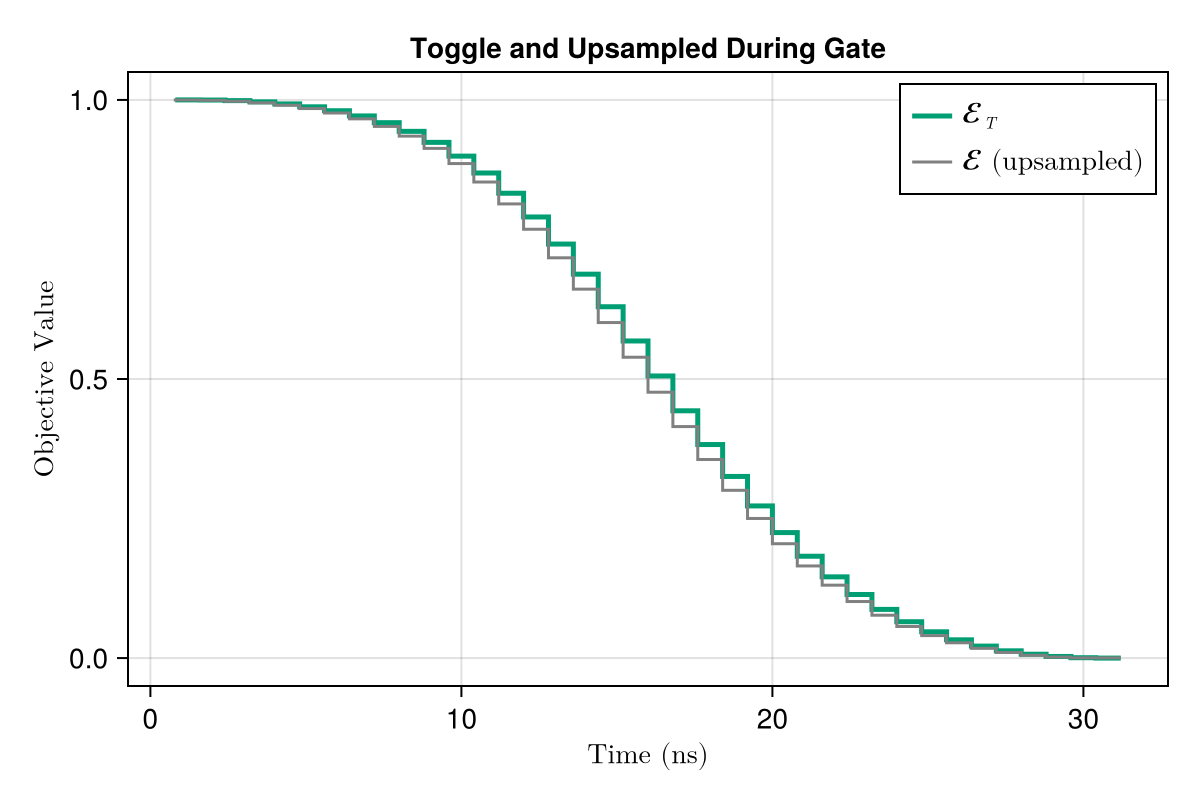

In [110]:
colors = Makie.wong_colors()


# Labels
script_tog = latexstring("\\mathcal{E}_{T}")
script_tog_up = latexstring("\\mathcal{E} \\text{ (upsampled)}")
script_diff = latexstring("\\text{Error}")

# Get trajectory info
tog_prob = tog_probs[end, end]
factor_up = 2^7
T = tog_prob.trajectory.T-1
T_upsampled = T * factor_up
Δt = tog_prob.trajectory.Δt[1]

# Compute objectives - coarse
objs_tog = [tog_obj(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t) for t in 1:T]

objs_tog_up = [tog_obj_upsample(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t; factor=factor_up) for t in 1:T]

# Time axes
ts = (1:T) .* Δt

# Create figure
fig = Figure(size = (600, 400))
ax_main = Axis(fig[1, 1],
    title = "Toggle and Upsampled During Gate",
    xlabel = LaTeXString("Time (ns)"), 
    ylabel = LaTeXString("Objective Value"),
    # yscale=log10,
)
# xlims!(ax_main, 30, 31.4)

# Plot coarse trajectory
stairs!(ax_main, ts, objs_tog, 
    step = :pre,
    label = script_tog,
    linewidth = 2.5,
    color = colors[3]
)

# Plot upsampled trajectory
stairs!(ax_main, ts, objs_tog_up, 
    step = :pre,
    label = script_tog_up,
    linewidth = 1.5,
    color = :gray
)


axislegend(ax_main, position = :rt)

fig

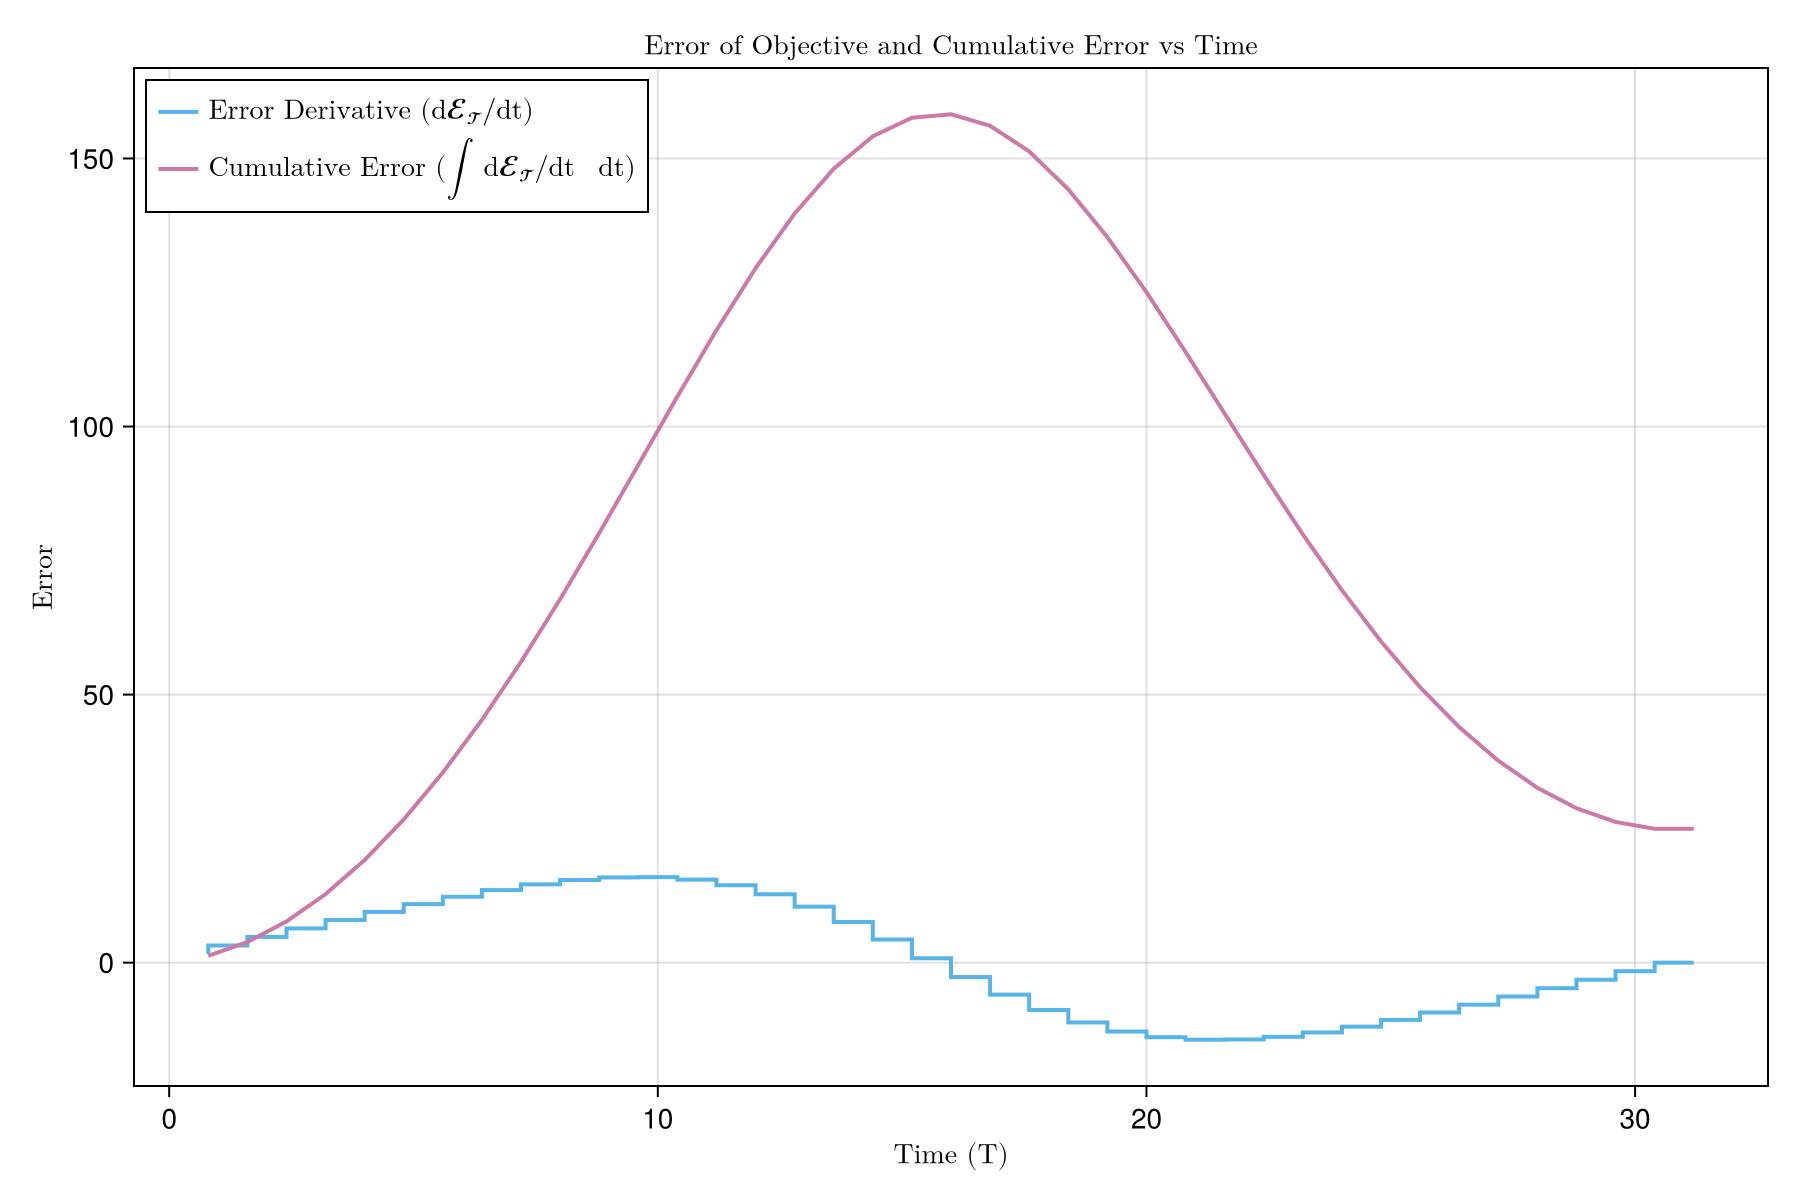

In [44]:
colors = Makie.wong_colors()

var_prob = var_probs[end, end]
tog_prob = tog_probs[end, end]
T = var_prob.trajectory.T-1
Δt = tog_prob.trajectory.Δt[1]

# Compute error derivative at each timestep
error_derivatives = [real(tog_deriv_up(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t; factor=1)) for t in 1:T]

# Compute cumulative error (integral of derivative)
cumulative_error = cumsum(error_derivatives .* Δt)
ts = (1:T) .* Δt

fig = Figure(size = (900, 600))

ax = Axis(fig[1, 1],
    title = LaTeXString("Error of Objective and Cumulative Error vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("Error"),
)

# Plot the derivative (instantaneous error)
stairs!(ax, ts, error_derivatives,
    step = :pre,
    label = LaTeXString("Error Derivative (d\\mathcal{E_T}/dt)"),
    linewidth = 2,
    color = colors[5]
)

# Plot the cumulative error (integral)
lines!(ax, ts, cumulative_error,
    label = LaTeXString("Cumulative Error (\\int d\\mathcal{E_T}/dt \\, dt)"),
    linewidth = 2,
    color = colors[4]
)

# Add legend
axislegend(ax, position = :lt)

# Display the figure
fig

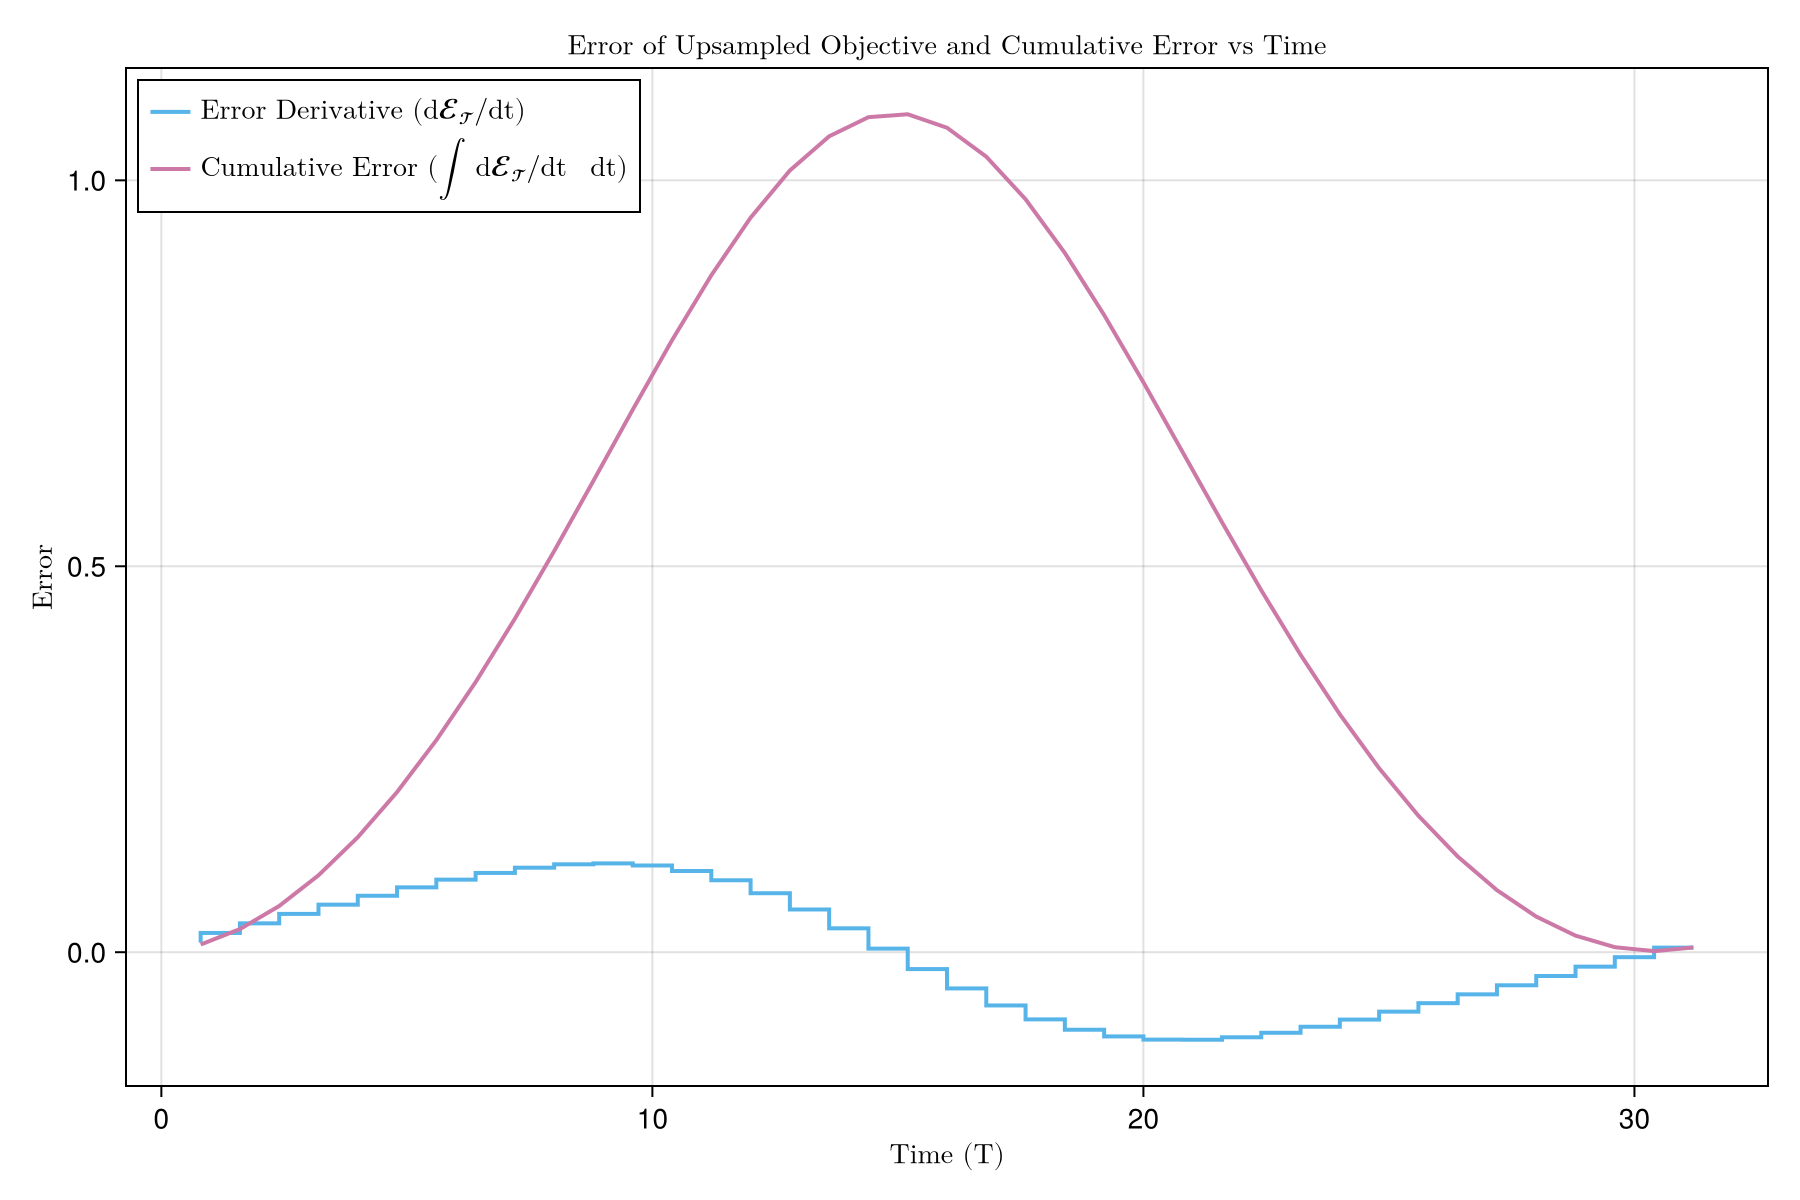

In [42]:
colors = Makie.wong_colors()
factor_up = 2^7
var_prob = var_probs[end, end]
tog_prob = tog_probs[end, end]
T = var_prob.trajectory.T-1
Δt = tog_prob.trajectory.Δt[1]

# Compute error derivative at each timestep
error_derivatives_up = [real(tog_deriv_up(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t;factor=factor_up)) for t in 1:T] ./ factor_up

# Compute cumulative error (integral of derivative)
cumulative_error_up = cumsum(error_derivatives_up .* Δt)
ts = (1:T) .* Δt

fig = Figure(size = (900, 600))

ax = Axis(fig[1, 1],
    title = LaTeXString("Error of Upsampled Objective and Cumulative Error vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("Error"),
)

# Plot the derivative (instantaneous error)
stairs!(ax, ts, error_derivatives_up,
    step = :pre,
    label = LaTeXString("Error Derivative (d\\mathcal{E_T}/dt)"),
    linewidth = 2,
    color = colors[5]
)

# Plot the cumulative error (integral)
lines!(ax, ts, cumulative_error_up,
    label = LaTeXString("Cumulative Error (\\int d\\mathcal{E_T}/dt \\, dt)"),
    linewidth = 2,
    color = colors[4]
)

# Add legend
axislegend(ax, position = :lt)

# Display the figure
fig

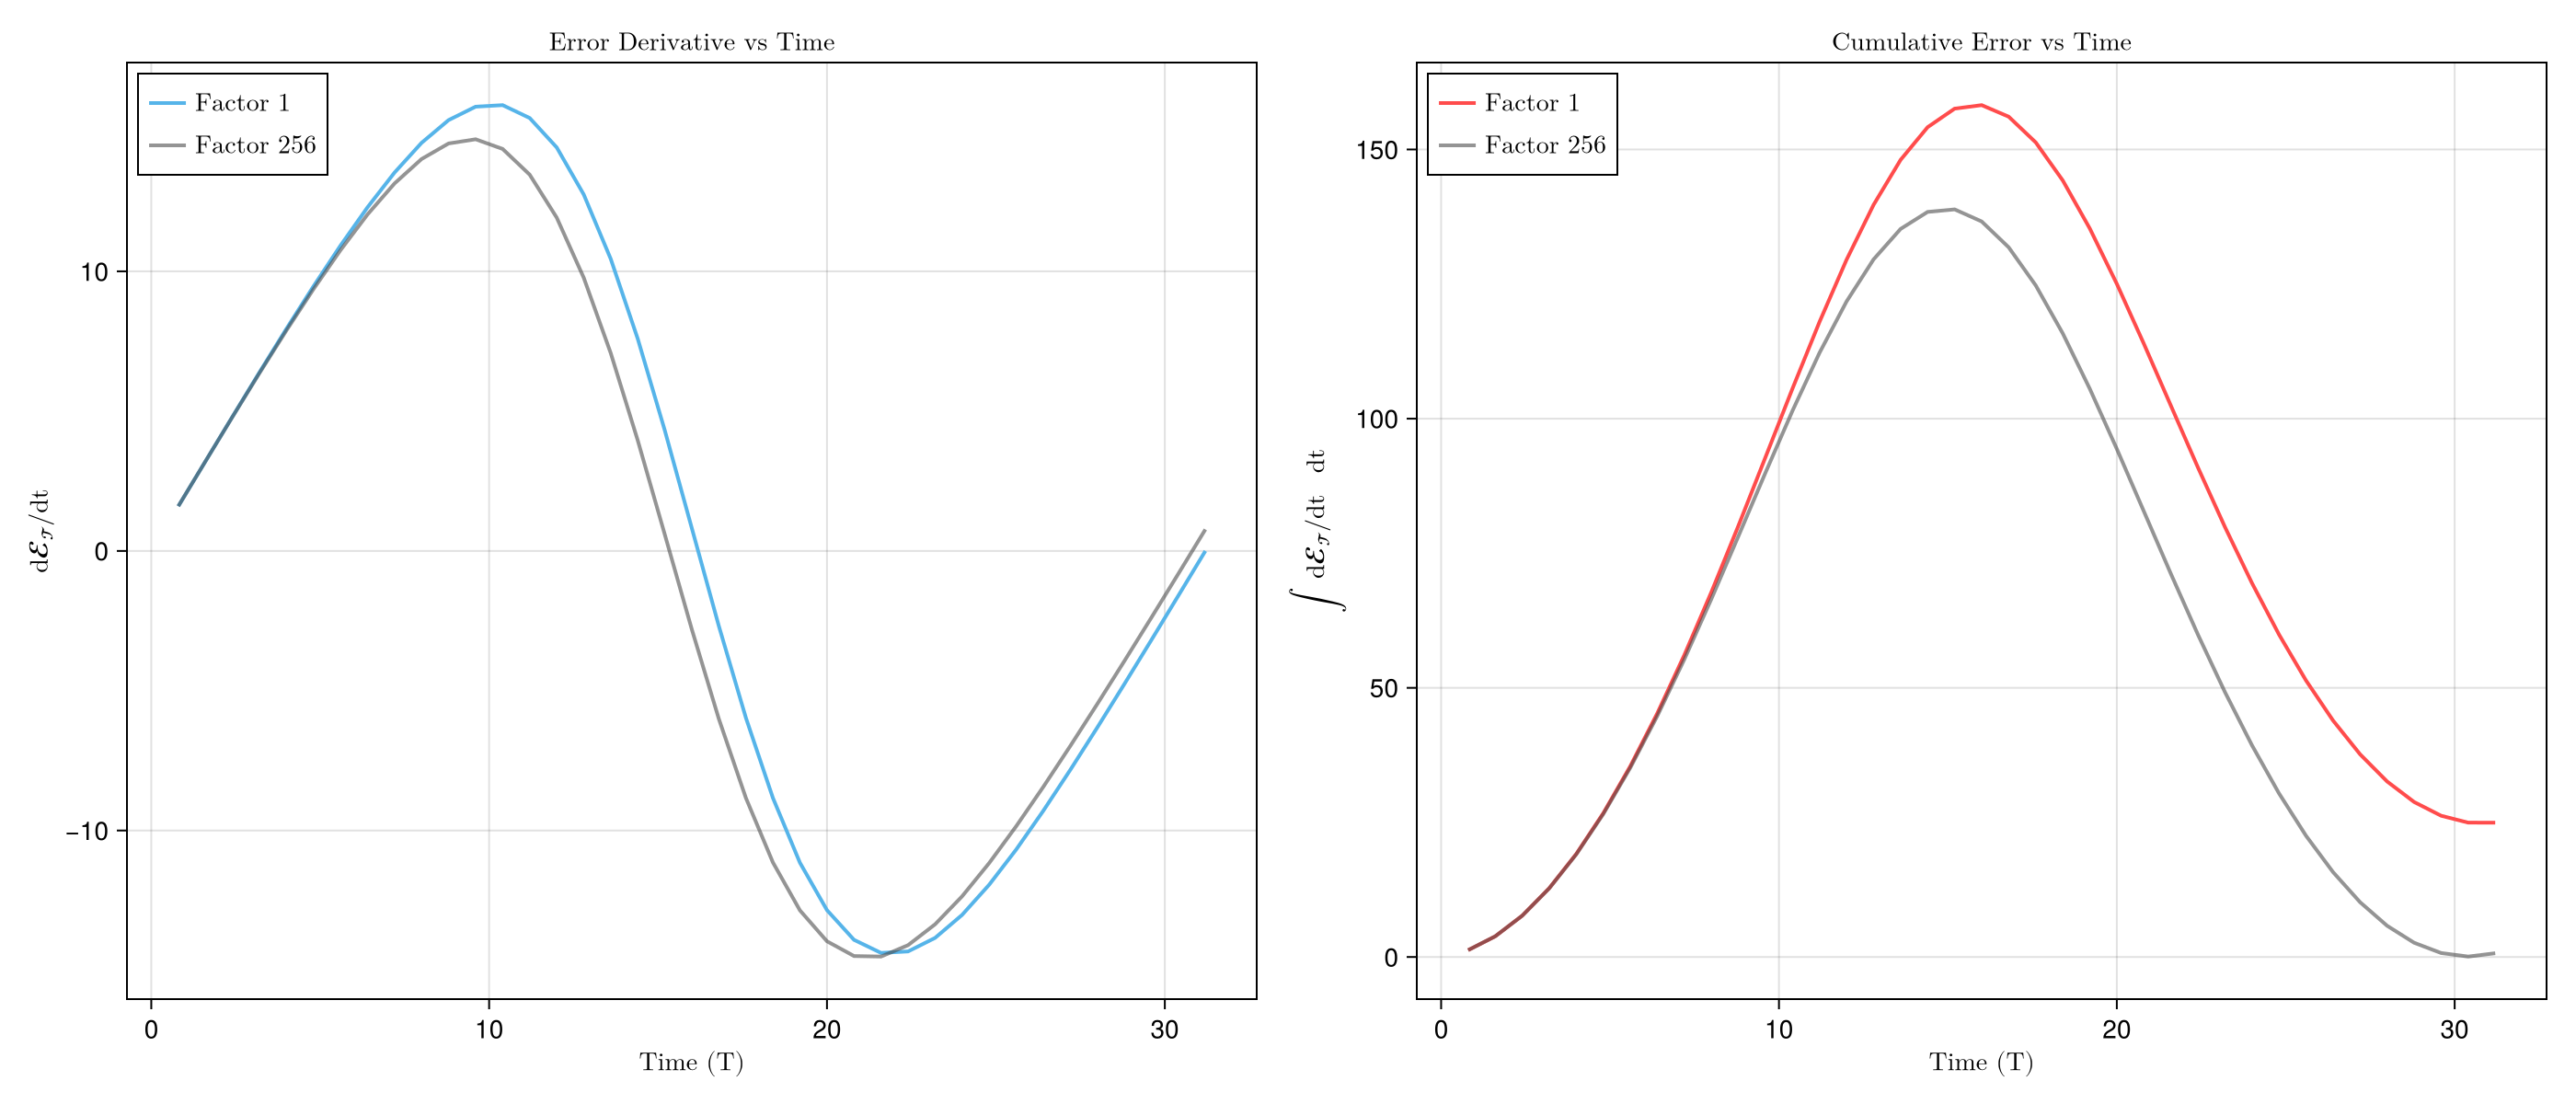

In [63]:
colors = Makie.wong_colors()

var_prob = var_probs[end, end]
tog_prob = tog_probs[end, end]
T = var_prob.trajectory.T-1
Δt = tog_prob.trajectory.Δt[1]

factors = [2^0, 2^8]

fig = Figure(size = (1400, 600))

# Left subplot for derivatives (blue/teal lines)
ax1 = Axis(fig[1, 1],
    title = LaTeXString("Error Derivative vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("d\\mathcal{E_T}/dt"),
)

# Right subplot for cumulative error (red/orange lines)
ax2 = Axis(fig[1, 2],
    title = LaTeXString("Cumulative Error vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("\\int d\\mathcal{E_T}/dt \\, dt"),
)

ts = (1:T) .* Δt

# Plot for each factor with fading color and transparency
for (i, factor) in enumerate(factors)
    # Compute error derivative at each timestep for this factor
    error_derivatives = [real(tog_deriv_up(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t; factor=factor)) for t in 1:T]
    
    # Compute cumulative error (integral of derivative)
    cumulative_error = cumsum(error_derivatives .* Δt)
    
    # Calculate alpha (transparency) - increases with factor
    alpha = 1.0 / (i^0.8)
    
    # Create faded colors - last factor is dark gray for both plots
    if i == length(factors)
        color_deriv = (0.3, 0.3, 0.3, 0.6)  # Dark gray, fully opaque
        color_cumul = (0.3, 0.3, 0.3, 0.6)  # Dark gray, fully opaque
    else
        color_deriv = (colors[5], alpha)  # Blue/teal with fading
        color_cumul = (1.0, 0.3, 0.3, alpha)  # Light red fading to darker red
    end
    
    # Plot the derivative on left subplot with continuous lines
    lines!(ax1, ts, error_derivatives,
        label = LaTeXString("Factor $(factor)"),
        linewidth = 2,
        color = color_deriv
    )
    
    # Plot the cumulative error on right subplot
    lines!(ax2, ts, cumulative_error,
        label = LaTeXString("Factor $(factor)"),
        linewidth = 2,
        color = color_cumul
    )
end

# Add legends
axislegend(ax1, position = :lt)
axislegend(ax2, position = :lt)

# Display the figure
fig

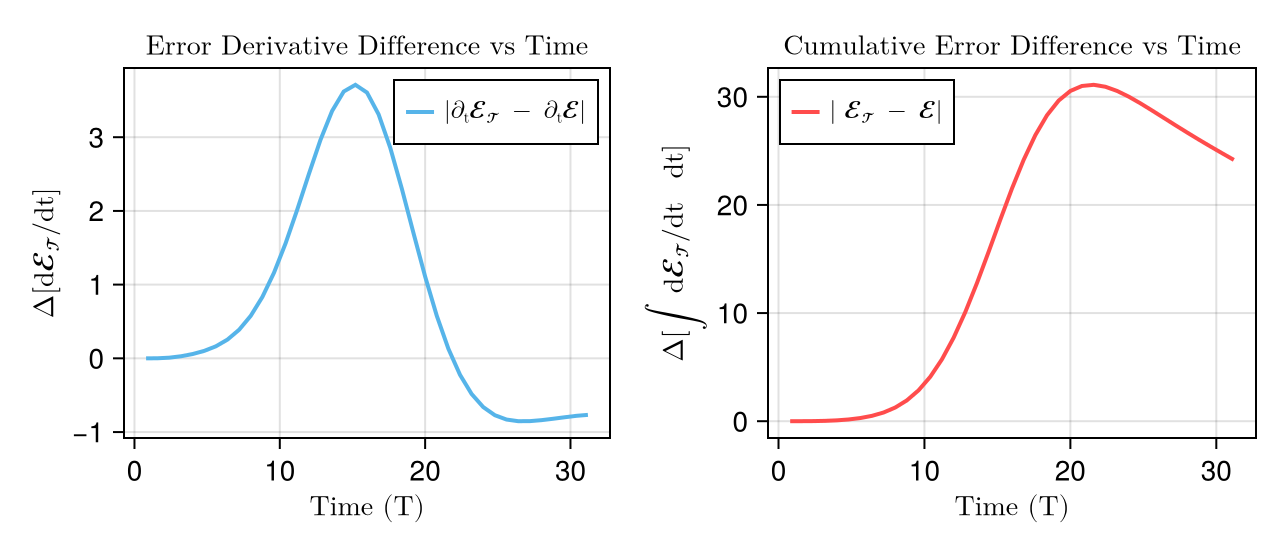

In [108]:
colors = Makie.wong_colors()

var_prob = var_probs[end, end]
tog_prob = tog_probs[end, end]
T = var_prob.trajectory.T-1
Δt = tog_prob.trajectory.Δt[1]

factors = [2^0, 2^7]

fig = Figure(size = (560*1.15, 1.15*240))

# Left subplot for derivatives (blue/teal lines)
ax1 = Axis(fig[1, 1],
    title = LaTeXString("Error Derivative Difference vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("\\Delta[d\\mathcal{E_T}/dt]"),
)

# Right subplot for cumulative error (red/orange lines)
ax2 = Axis(fig[1, 2],
    title = LaTeXString("Cumulative Error Difference vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("\\Delta[\\int d\\mathcal{E_T}/dt \\, dt]"),
)

ts = (1:T) .* Δt

# Compute error derivatives for both factors
error_derivatives_baseline = [real(tog_deriv_up(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t; factor=factors[2])) for t in 1:T]
error_derivatives_high = [real(tog_deriv_up(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t; factor=factors[1])) for t in 1:T]

# Compute differences
derivative_diff = error_derivatives_high .- error_derivatives_baseline

# Compute cumulative errors for both factors
cumulative_error_baseline = cumsum(error_derivatives_baseline .* Δt)
cumulative_error_high = cumsum(error_derivatives_high .* Δt)

# Compute cumulative difference
cumulative_diff = cumulative_error_high .- cumulative_error_baseline

# Plot the derivative difference
lines!(ax1, ts, derivative_diff,
    label = LaTeXString("|\\partial_t{\\mathcal{E_T}} - \\partial_t{\\mathcal{E}}|"),
    linewidth = 2,
    color = colors[5]
)

# Plot the cumulative error difference
lines!(ax2, ts, cumulative_diff,
    label = LaTeXString("| \\mathcal{E_T} - \\mathcal{E}|"),
    linewidth = 2,
    color = (1.0, 0.3, 0.3, 1.0)
)

# Add legends
axislegend(ax1, position = :rt, patchsize = (14, 20), labelsize=12)
axislegend(ax2, position = :lt, patchsize = (14, 20), labelsize=12)

# Display the figure
fig

In [48]:
colors = Makie.wong_colors()

var_prob = var_probs[end, end]
tog_prob = tog_probs[end, end]
T = var_prob.trajectory.T-1
Δt = tog_prob.trajectory.Δt[1]

factors = [2^0, 2^1, 2^2, 2^7]

fig = Figure(size = (1400, 600))

# Left subplot for derivatives (blue/teal lines)
ax1 = Axis(fig[1, 1],
    title = LaTeXString("Error Derivative vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("d\\mathcal{E_T}/dt"),
    yscale=log10,
)

# Right subplot for cumulative error (red/orange lines)
ax2 = Axis(fig[1, 2],
    title = LaTeXString("Cumulative Error vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("\\int d\\mathcal{E_T}/dt \\, dt"),
    yscale=log10,
)

ts = (1:T) .* Δt

# Plot for each factor with fading color and transparency
for (i, factor) in enumerate(factors)
    # Compute error derivative at each timestep for this factor
    error_derivatives = [real(tog_deriv_up(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t; factor=factor)) for t in 1:T]
    
    # Compute cumulative error (integral of derivative)
    cumulative_error = cumsum(error_derivatives .* Δt)
    
    # Calculate alpha (transparency) - increases with factor
    alpha = 1.0 / (i^0.8)
    
    # Create faded colors - last factor is dark gray for both plots
    if i == length(factors)
        color_deriv = (0.3, 0.3, 0.3, 0.6)  # Dark gray, fully opaque
        color_cumul = (0.3, 0.3, 0.3, 0.6)  # Dark gray, fully opaque
    else
        color_deriv = (colors[5], alpha)  # Blue/teal with fading
        color_cumul = (1.0, 0.3, 0.3, alpha)  # Light red fading to darker red
    end
    
    # Plot the derivative on left subplot with continuous lines
    lines!(ax1, ts, error_derivatives,
        label = LaTeXString("Factor $(factor)"),
        linewidth = 2,
        color = color_deriv
    )
    
    # Plot the cumulative error on right subplot
    lines!(ax2, ts, cumulative_error,
        label = LaTeXString("Factor $(factor)"),
        linewidth = 2,
        color = color_cumul
    )
end

# Add legends
axislegend(ax1, position = :lt)
axislegend(ax2, position = :lt)

# Display the figure
fig

In [92]:

"""
    tog_obj_upsample(
        traj::NamedTrajectory, 
        H_drives::Vector{Matrix{ComplexF64}}, 
        H_error::Matrix{ComplexF64}, 
        t_cut::Int=traj.T;
        factor::Int=1,
    )

Calculates the *cumulative* toggle objective at *each upsampled time step*.
"""
function tog_obj_upsample_full(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}}, 
    H_error::Matrix{ComplexF64}, 
    t_cut::Int=traj.T; # t_cut defines the *input* coarse slice to upsample
    factor::Int=1,
)
    # --- 1. Upsample Controls and Time Steps ---
    T_upsampled = t_cut * factor
    controls_slice = traj.a[:, 1:t_cut]
    dts_slice = traj.Δt[1:t_cut]
    a_new, Δt_new = upsample_matrix(controls_slice, dts_slice; factor=factor)
    
    # Ensure Δt_new has the correct length
    if length(Δt_new) != T_upsampled
        # println("Warning: Mismatch in upsampled time steps. Reconstructing.")
        dt_up_val = dts_slice[1] / factor
        Δt_new = fill(dt_up_val, T_upsampled)
    end

    # --- 2. Perform Unitary Rollout ---
    sys = QuantumSystem(H_drives)
    # Note: unitary_rollout needs to accept (controls, dts, sys)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(a_new, Δt_new, sys)))
    
    d₁ = size(U[1], 1)
    
    # --- 3. Calculate Cumulative Metric ---
    # We create a vector of metrics, one for each upsampled time step.
    
    metrics_up = zeros(Float64, T_upsampled)
    H_ti_cumulative = zeros(ComplexF64, d₁, d₁)
    T_total_cumulative = 0.0
    
    for i in 1:T_upsampled
        # Add the contribution from this upsampled time step
        H_ti_cumulative .+= (Δt_new[i] .* U[i]' * H_error * U[i])
        
        # Add to the total time
        T_total_cumulative += Δt_new[i]
        
        # Calculate the metric, same as in tog_obj
        if T_total_cumulative > 1e-9 # Avoid division by zero
            metric_i = abs(tr(H_ti_cumulative' * H_ti_cumulative)) / T_total_cumulative^2 / d₁
            metrics_up[i] = metric_i
        else
            metrics_up[i] = 0.0 # Metric is 0 at time 0
        end
    end
    
    # Return the full vector of cumulative metrics
    return metrics_up
end

tog_obj_upsample_full

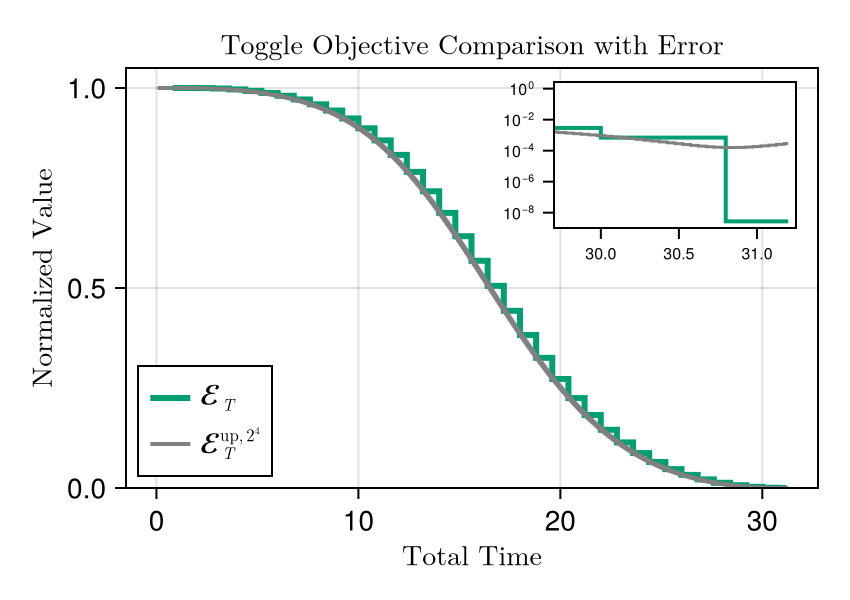

In [93]:
colors = Makie.wong_colors()

script_tog = latexstring("\\mathcal{E}_{T}")
script_tog_up = latexstring("\\mathcal{E}_{T}^{\\mathrm{up},\\,2^{4}}") # Using 2^11
script_pert = [latexstring("\\mathcal{E}_{T}^{(2)}"), 
               latexstring("\\mathcal{E}_{T}^{(3)}"), 
               latexstring("\\mathcal{E}_{T}^{(4)}")]

# Get trajectory info
var_prob = var_probs[end, end]
tog_prob = tog_probs[end, end]
T = var_prob.trajectory.T-1
dt_coarse = tog_prob.trajectory.Δt[1]

# Coarse Objective (Length T)
# This creates a vector of T cumulative objectives
objs_tog = [tog_obj(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t) for t in 1:T]

# Full Upsampled Objective (Length T * factor_up)
factor_up = 2^4 # Using 2^11
# ---
# MODIFICATION IS HERE:
# `tog_obj_upsample` now returns a vector of length T*factor_up
# ---
objs_tog_up_full = tog_obj_upsample_full(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], T; factor=factor_up)

# Create BOTH time axes
time_axis_coarse = (1:T) .* dt_coarse
T_up_total = T * factor_up
dt_up = dt_coarse / factor_up
time_axis_up = (1:T_up_total) .* dt_up

# --- 2. Normalize ALL Data to 0-1 Range ---

# a) Find the global maximum of the objective plots
#    This now works because both inputs are vectors.
global_max_obj = maximum([maximum(objs_tog), maximum(objs_tog_up_full)])

# b) Normalize the objective plots
objs_tog_norm = objs_tog ./ global_max_obj
objs_tog_up_full_norm = objs_tog_up_full ./ global_max_obj # This is now a vector

# c) Create a *centered* upsampled version of the coarse objective for the band!
#    This is necessary to align with the 'step = :center' of the stairs! plot.
t_coarse_midpoints = [ (i - 1) * dt_coarse for i in 1:(T+1) ] 
# t_coarse_midpoints will be [0.0, 1.0, 2.0, ..., T] .* dt_coarse
# We'll use 0.5-based midpoints for checking
t_coarse_step_points = [ (i - 0.5) * dt_coarse for i in 1:(T) ]
t_coarse_step_points = [0.0; t_coarse_step_points; T * dt_coarse] # Boundaries

objs_tog_norm_centered_upsampled = similar(time_axis_up)
coarse_idx = 1
for i in 1:length(time_axis_up)
    # Check if we've passed the *next* step-change boundary
    if coarse_idx <= T && time_axis_up[i] > t_coarse_step_points[coarse_idx + 1]
        coarse_idx += 1
    end
    # Ensure coarse_idx stays within bounds
    current_coarse_idx = min(coarse_idx, T)
    objs_tog_norm_centered_upsampled[i] = objs_tog_norm[current_coarse_idx]
end

# --- 3. Create the Figure and Main Plot ---

fig = Figure(size = (425, 300))

ax_main = Axis(fig[1, 1],
    title = LaTeXString("Toggle Objective Comparison with Error"),
    xlabel = LaTeXString("Total Time"), 
    ylabel = LaTeXString("Normalized Value"), 
)

# Set Y-axis limits for the main plot
ylims!(ax_main, 0, 1.05)

# b) Plot Normalized Coarse trajectory
stairs!(ax_main, time_axis_coarse, objs_tog_norm, 
    step = :center,
    label = script_tog,
    linewidth = 3,
    color = colors[3],
    linestyle = :solid
)

# c) Plot Normalized High-resolution upsampled trajectory
#    This now plots the full vector.
stairs!(ax_main, time_axis_up, objs_tog_up_full_norm, 
    step = :center, # Use :center to align with coarse steps
    label = script_tog_up,
    linewidth = 2,
    color = :gray,
    linestyle = :solid
)

# --- 4. NEW: Create Inset Plot ---

# a) Create an opaque white box to act as a "backing" for the inset
#    This ensures it fully covers the main plot's grid lines.
Box(fig[1, 1],
    width = Relative(0.35),
    height = Relative(0.35),
    halign = 0.95,
    valign = 0.95,
    color = :white,
    strokewidth = 0
)

# b) Create the new Axis, placing it in the same spot
ax_inset = Axis(fig[1, 1],
    width = Relative(0.35),  # 35% of the main plot's width
    height = Relative(0.35), # 35% of the main plot's height
    halign = 0.95,           # 95% to the right
    valign = 0.95,           # 95% from the bottom (This places it top-right)
    backgroundcolor = :white, # Make it opaque
    xticklabelsize = 8,      # Smaller tick labels
    yticklabelsize = 8,
    # title = "zoom 14<t<16", # Add a title to the inset
    yscale=log10,
)

# c) Set the x-limits for the zoom
xlims!(ax_inset, 29.7, 31.25)
# ylims!(ax_inset, 0.00001, 0.001)
# (We let y-axis auto-limit to the data in this range)

# d) Plot the same data onto the inset axis (no labels)
stairs!(ax_inset, time_axis_coarse, objs_tog_norm, 
    step = :center,
    linewidth = 2,
    color = colors[3],
    linestyle = :solid
)

stairs!(ax_inset, time_axis_up, objs_tog_up_full_norm, 
    step = :center,
    linewidth = 1.5,
    color = :gray,
    linestyle = :solid
)

# --- 5. Add Legend to Main Plot ---
axislegend(ax_main, position = :lb)

# Display the figure
fig

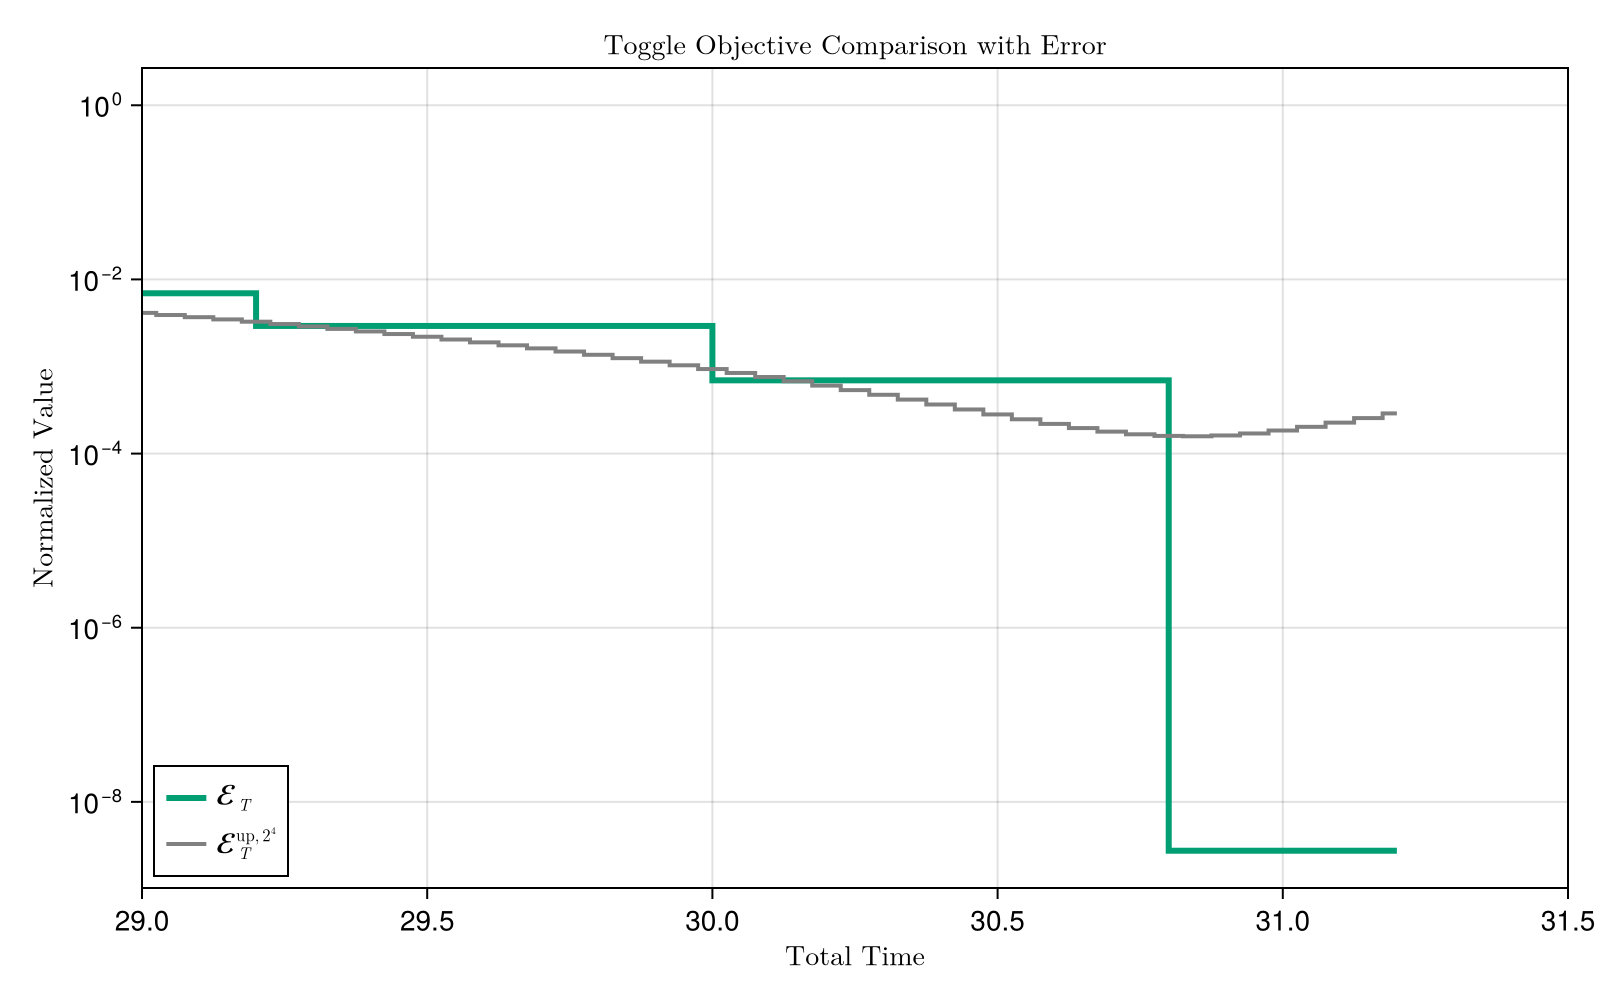

In [62]:
# colors = Makie.wong_colors()

# script_tog = latexstring("\\mathcal{E}_{T}")
# script_tog_up = latexstring("\\mathcal{E}_{T}^{\\mathrm{up},\\,2^{4}}") # Using 2^11
# script_pert = [latexstring("\\mathcal{E}_{T}^{(2)}"), 
#                latexstring("\\mathcal{E}_{T}^{(3)}"), 
#                latexstring("\\mathcal{E}_{T}^{(4)}")]

# # Get trajectory info
# var_prob = var_probs[end, end]
# tog_prob = tog_probs[end, end]
# T = var_prob.trajectory.T-1
# dt_coarse = tog_prob.trajectory.Δt[1]

# # Coarse Objective (Length T)
# # This creates a vector of T cumulative objectives
# objs_tog = [tog_obj(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t) for t in 1:T]

# # Full Upsampled Objective (Length T * factor_up)
# factor_up = 2^4 # Using 2^11
# # ---
# # MODIFICATION IS HERE:
# # `tog_obj_upsample` now returns a vector of length T*factor_up
# # ---
# objs_tog_up_full = tog_obj_upsample_full(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], T; factor=factor_up)

# # Create BOTH time axes
# time_axis_coarse = (1:T) .* dt_coarse
# T_up_total = T * factor_up
# dt_up = dt_coarse / factor_up
# time_axis_up = (1:T_up_total) .* dt_up

# # --- 2. Normalize ALL Data to 0-1 Range ---

# # a) Find the global maximum of the objective plots
# #    This now works because both inputs are vectors.
# global_max_obj = maximum([maximum(objs_tog), maximum(objs_tog_up_full)])

# # b) Normalize the objective plots
# objs_tog_norm = objs_tog ./ global_max_obj
# objs_tog_up_full_norm = objs_tog_up_full ./ global_max_obj # This is now a vector

# # c) Create a *centered* upsampled version of the coarse objective for the band!
# #    This is necessary to align with the 'step = :center' of the stairs! plot.
# t_coarse_midpoints = [ (i - 1) * dt_coarse for i in 1:(T+1) ] 
# # t_coarse_midpoints will be [0.0, 1.0, 2.0, ..., T] .* dt_coarse
# # We'll use 0.5-based midpoints for checking
# t_coarse_step_points = [ (i - 0.5) * dt_coarse for i in 1:(T) ]
# t_coarse_step_points = [0.0; t_coarse_step_points; T * dt_coarse] # Boundaries

# objs_tog_norm_centered_upsampled = similar(time_axis_up)
# coarse_idx = 1
# for i in 1:length(time_axis_up)
#     # Check if we've passed the *next* step-change boundary
#     if coarse_idx <= T && time_axis_up[i] > t_coarse_step_points[coarse_idx + 1]
#         coarse_idx += 1
#     end
#     # Ensure coarse_idx stays within bounds
#     current_coarse_idx = min(coarse_idx, T)
#     objs_tog_norm_centered_upsampled[i] = objs_tog_norm[current_coarse_idx]
# end

# # --- 3. Create the Figure and Main Plot ---

# fig = Figure(size = (800, 500))

# ax_main = Axis(fig[1, 1],
#     title = LaTeXString("Toggle Objective Comparison with Error"),
#     xlabel = LaTeXString("Total Time"), 
#     ylabel = LaTeXString("Normalized Value"), 
#     yscale=log10,
# )

# # Set Y-axis limits for the main plot
# xlims!(ax_main, 29, 31.5)

# # b) Plot Normalized Coarse trajectory
# stairs!(ax_main, time_axis_coarse, objs_tog_norm, 
#     step = :center,
#     label = script_tog,
#     linewidth = 3,
#     color = colors[3],
#     linestyle = :solid
# )

# # c) Plot Normalized High-resolution upsampled trajectory
# #    This now plots the full vector.
# stairs!(ax_main, time_axis_up, objs_tog_up_full_norm, 
#     step = :center, # Use :center to align with coarse steps
#     label = script_tog_up,
#     linewidth = 2,
#     color = :gray,
#     linestyle = :solid
# )

# # --- 5. Add Legend to Main Plot ---
# axislegend(ax_main, position = :lb)

# # Display the figure
# fig

In [ ]:
using CairoMakie
using GeometryBasics

f  = CairoMakie.Figure(resolution = (800, 600))
ax = CairoMakie.Axis3(f[1, 1];
    aspect = :equal
)

palette = to_colormap(:tab10)
styles  = (:solid, :dash, :dot, :dashdot)

origins = [Point3f(0,0,0), Point3f(0,0,0), Point3f(0,0,0)]
dirs    = [Vec3f(1.0,0,0), Vec3f(0,1.0,0), Vec3f(0,0,1.0)]

CairoMakie.arrows!(ax, origins, dirs;
    color = [:red, :green, :blue],
    arrowsize = 0.05,
    linewidth = 0.01
)

CairoMakie.text!(ax, "x", position = Point3f(1.2, 0, 0), align = (:left, :center),  color = :red,   fontsize = 28)
CairoMakie.text!(ax, "y", position = Point3f(0, 1.2, 0), align = (:center, :bottom), color = :green, fontsize = 28)
CairoMakie.text!(ax, "z", position = Point3f(0, 0, 1.2), align = (:center, :bottom), color = :blue,  fontsize = 28)

CairoMakie.lines!(ax, real.(expect_val_x), real.(expect_val_y), real.(expect_val_z);
    color     = palette[1],
    linestyle = styles[1],
    label     = "|0⟩ to |+⟩, default",
    linewidth = 1.5
)

CairoMakie.lines!(ax, real.(expect_val_x_1), real.(expect_val_y_1), real.(expect_val_z_1);
    color     = palette[2],
    linestyle = styles[1],
    label     = "|0⟩ to |+⟩, robust",
    linewidth = 1.5
)

CairoMakie.scatter!(ax, [real(expect_val_x[end])], [real(expect_val_y[end])], [real(expect_val_z[end])];
    color = palette[1], markersize = 20, marker = :xcross)

CairoMakie.scatter!(ax, [real(expect_val_x_1[end])], [real(expect_val_y_1[end])], [real(expect_val_z_1[end])];
    color = palette[2], markersize = 15, marker = :circle)

CairoMakie.mesh!(ax, Sphere(Point3f(0,0,0), 1f0);
    color = (0.2, 0.6, 1.0, 0.05),
    transparency = true,
    shading = true
)

CairoMakie.xlims!(ax, -1.3, 1.3)
CairoMakie.ylims!(ax, -1.3, 1.3)
CairoMakie.zlims!(ax, -1.3, 1.3)

ax.azimuth[]   =  π/4
ax.elevation[] =  π/6

CairoMakie.axislegend(ax; position = :rt)
CairoMakie.hidexdecorations!(ax, grid = false)
CairoMakie.hideydecorations!(ax, grid = false)
CairoMakie.hidezdecorations!(ax, grid = false)

f
     